# Computer Vision and Language Models project

Group: The Karate Kid

- [Ettore Ricci](https://github.com/Etto48)
- [Paolo Palumbo](https://github.com/paolpal)
- [Zahra Omrani](https://github.com/zahra-omrani)
- [Erni Delialisi](https://github.com/erni-de)

## Introduction

The goal of this project is to build a model that can generate a textual description of an image.
We used the [COCO dataset](https://cocodataset.org/#home).
Our model is a combination of a pre-trained ViT and a GPT-like model trained from scratch.

The pre-trained ViT is [DINOv2](https://arxiv.org/abs/2304.07193).

In [1]:
from typing import Literal, Optional
import torch
from torch import nn
import tiktoken
from tqdm.auto import tqdm
import transformers
import json
import os
from torch.utils.data import Dataset
import pandas as pd
import torchvision
import torchvision.transforms.functional
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import patches
import sklearn
import sklearn.decomposition

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

/home/ettore/Documents/Notes/AIDE 2/Multimedia information retrieval and computer vision/CVProject/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Dataset

The dataset is the COCO dataset, which contains images and (among other things) their textual descriptions.
We used the 2017 version of the dataset, which can be downloaded from the [official website](https://cocodataset.org/#download).

In [2]:
class TextImageDataset(Dataset):
    def __init__(self, df: pd.DataFrame):
        assert 'caption' in df.columns
        assert 'image_path' in df.columns
        self.df = df
        self.tokenizer = tiktoken.get_encoding("gpt2")
    
    @staticmethod
    def load(captions_path: str, images_path: str):
        img_name_padding = 12
        
        with open(captions_path, "r") as f:
            captions_data = json.load(f)["annotations"]
        df_list = []
        for caption_data in tqdm(captions_data, desc="Loading dataset"):
            image_id = caption_data["image_id"]
            caption = caption_data["caption"]
            image_name = f"{str(image_id).zfill(img_name_padding)}.jpg"
            image_path = os.path.join(images_path, image_name)
            df_list.append({"caption": caption, "image_path": image_path})
        df = pd.DataFrame.from_dict(df_list)
        return TextImageDataset(df)
    
    @staticmethod
    def load_train():
        return TextImageDataset.load("/home/ettore/Downloads/COCO/annotations_trainval2017/annotations/captions_train2017.json", "/home/ettore/Downloads/COCO/train2017")
    
    @staticmethod
    def load_valid():
        return TextImageDataset.load("/home/ettore/Downloads/COCO/annotations_trainval2017/annotations/captions_val2017.json", "/home/ettore/Downloads/COCO/val2017")
    
    def __len__(self):  
        return len(self.df)

    def _load_image(self, image_path: str):
        image = torchvision.io.decode_image(torchvision.io.read_file(image_path))
        if image.shape[0] == 1:
            image = image.repeat(3, 1, 1)
        return image
    
    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        caption = row["caption"]
        plaintext_caption = caption
        image_path = row["image_path"]
        image = self._load_image(image_path)
        caption = [self.tokenizer.max_token_value] + self.tokenizer.encode(caption) + [self.tokenizer.max_token_value]
        caption = torch.tensor(caption, dtype=torch.long)
        return image, caption, plaintext_caption
    
    @staticmethod
    def collate_fn(batch: list):
        images, captions, plaintext_caption = zip(*batch)
        lengths = torch.tensor([len(c) for c in captions])
        captions = torch.nn.utils.rnn.pad_sequence(captions, batch_first=True, padding_value=0)
        return images, captions, lengths, plaintext_caption

In [3]:
# train = TextImageDataset.load_train()
valid = TextImageDataset.load_valid()

Loading dataset: 100%|██████████| 25014/25014 [00:00<00:00, 730182.83it/s]


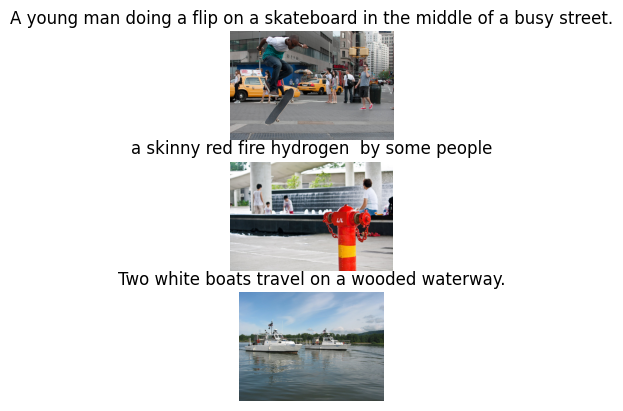

In [4]:
h = 3
w = 1
valid_loader = torch.utils.data.DataLoader(
    dataset=valid, batch_size=h*w, collate_fn=TextImageDataset.collate_fn,
    sampler=torch.utils.data.RandomSampler(valid, replacement=True, num_samples=h * w))
images, _, _, captions = next(iter(valid_loader))
for i in range(h*w):
    plt.subplot(h, w, i + 1)
    plt.imshow(images[i].permute(1, 2, 0))
    plt.title(captions[i])
    plt.axis("off")
plt.show()

## DINOv2

We used a pre-trained ViT model, DINOv2. It was trained with a self-supervised learning approach.
During the training, two models are trained: a teacher and a student.

The teacher model is used to generate the pseudo-labels for the student model.
The student model is trained to predict the pseudo-labels generated by the teacher model.

The resulting model is capable of extracting meaningful and robust features from the input images.

In [5]:
img_processor = transformers.AutoImageProcessor.from_pretrained('facebook/dinov2-base')
img_embedding = transformers.AutoModel.from_pretrained('facebook/dinov2-base')

Now we will display an example of the PCA of the features for some images.

The features are relative to their respective patch of the image.

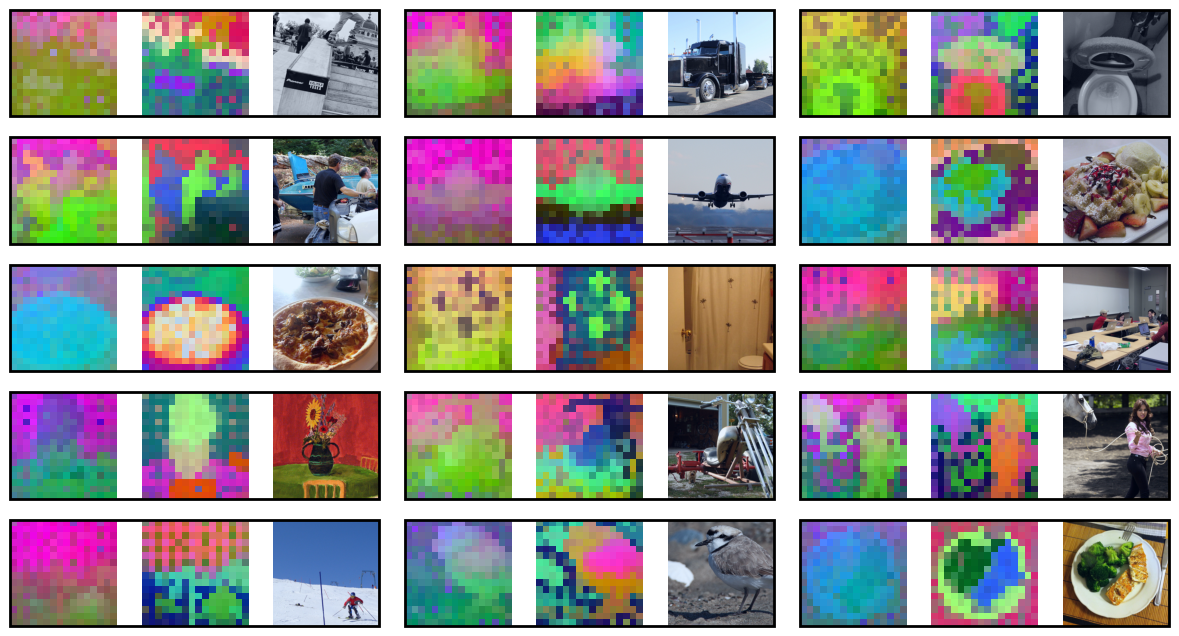

In [14]:
def image_embedding_to_pca(image_embedding: torch.Tensor):
    if len(image_embedding.shape) == 2:
        image_embedding = image_embedding.unsqueeze(0)
    assert len(image_embedding.shape) == 3, f"Expected 3D tensor of batched embeddings, got {image_embedding.shape}"
    batch_size = image_embedding.shape[0]
    image_embedding = image_embedding[:, 1:, :]
    edge_square = image_embedding.shape[1]
    feature_size = image_embedding.shape[2]
    edge = int(edge_square ** 0.5)
    assert edge ** 2 == edge_square, f"Expected square image embeddings, got {edge_square}"
    pca_local = [sklearn.decomposition.PCA(n_components=3)] * batch_size
    pca = sklearn.decomposition.PCA(n_components=3)
    pca.fit(image_embedding.reshape(batch_size * edge_square, feature_size))
    ret_local = []
    ret = []
    image_embedding = image_embedding.cpu().numpy()
    for i in range(batch_size):
        pca_local[i].fit(image_embedding[i])
        pca_img = pca.transform(image_embedding[i]).reshape(edge, edge, 3)
        pca_img = (pca_img - pca_img.min()) / (pca_img.max() - pca_img.min())
        ret.append(pca_img)
        pca_img_local = pca_local[i].transform(image_embedding[i]).reshape(edge, edge, 3)
        pca_img_local = (pca_img_local - pca_img_local.min()) / (pca_img_local.max() - pca_img_local.min())
        ret_local.append(pca_img_local)
    return ret, ret_local

h = 5
w = 3
valid_loader = torch.utils.data.DataLoader(
    dataset=valid, batch_size=h * w, collate_fn=TextImageDataset.collate_fn,
    sampler=torch.utils.data.RandomSampler(valid, replacement=False, num_samples=h * w))
images, _, _, _ = next(iter(valid_loader))
with torch.no_grad():
    preprocessed_images = img_processor(images, return_tensors="pt").to(device)
    image_embeddings = img_embedding(**preprocessed_images).last_hidden_state
pca, pca_local = image_embedding_to_pca(image_embeddings)
fig = plt.figure(figsize=(15, 8))
for i in range(h*w):
    plt.subplot(h, 3*w, 3*i + 1)
    plt.imshow(pca[i])
    plt.axis("off")
    begin = plt.gca().get_position()
    plt.subplot(h, 3*w, 3*i + 2)
    plt.imshow(pca_local[i])
    plt.axis("off")
    plt.subplot(h, 3*w, 3*i + 3)
    img = preprocessed_images["pixel_values"][i].permute(1, 2, 0)
    img = (img - img.min()) / (img.max() - img.min())
    plt.imshow(img)
    plt.axis("off")
    end = plt.gca().get_position()
    rect = patches.Rectangle((begin.x0, begin.y0), end.x1 - begin.x0, end.y1 - begin.y0, edgecolor='black', facecolor='none', lw=2, transform=fig.transFigure)
    fig.patches.append(rect)
plt.show()


In [7]:
class PositionalEncoding(nn.Module):
    def __init__(self):
        super().__init__()
        self.pe = None

    def set_pe(self, t, d, device):
        position = torch.arange(t, device=device).view(1, -1, 1)
        div_term = torch.exp(torch.arange(0, d, 2, device=device) * -np.log(10000.0) / d).view(1, 1, -1)
        self.pe = torch.zeros(1, t, d, device=device)
        self.pe[:, :, 0::2] = torch.sin(position * div_term)
        self.pe[:, :, 1::2] = torch.cos(position * div_term)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        _, t, d = x.size()
        if self.pe is None or t > self.pe.size(1) or d != self.pe.size(2) or self.pe.device != x.device:
            self.set_pe(t, d, x.device)

        x = x + self.pe[:, :t, :]
        return x

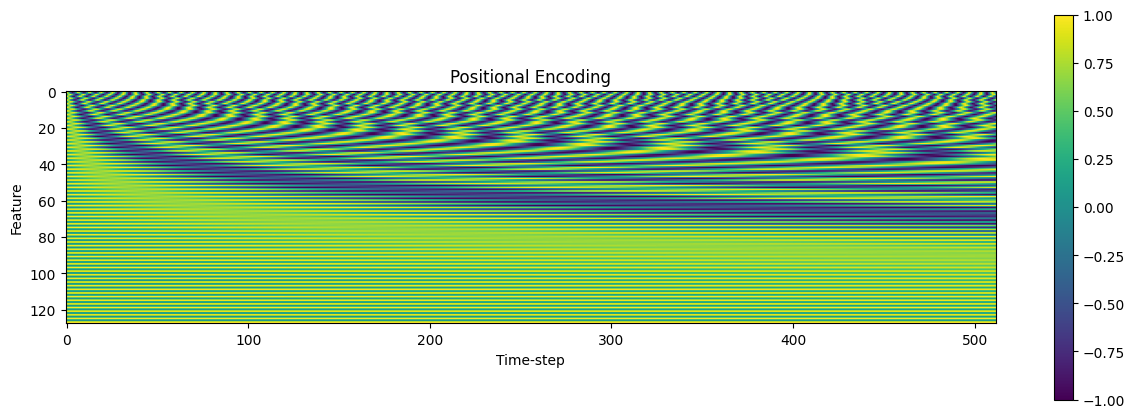

In [8]:
pe = PositionalEncoding()
x = torch.zeros(1, 512, 128)
y = pe(x)
plt.figure(figsize=(15, 5))
plt.title("Positional Encoding")
plt.imshow(y[0].T.detach().cpu().numpy())
plt.colorbar()
plt.xlabel("Time-step")
plt.ylabel("Feature")
plt.show()

In [9]:
class Annotator(nn.Module):
    def __init__(self):
        super().__init__()
        self.device = torch.device(
            "cuda" if torch.cuda.is_available() else "cpu")
        self.embedding_dim = 768
        self.heads = 12
        self.decoder_block_depth = 6
        self.decoder_blocks = 3
        self.dropout = 0.1

        self.tokenizer = tiktoken.get_encoding("gpt2")
        self.embedding = nn.Sequential(
            nn.Embedding(
                num_embeddings=self.tokenizer.max_token_value + 1,
                embedding_dim=self.embedding_dim,
            ),
        )

        self.positional_encoding = PositionalEncoding()
       
        self.img_processor = transformers.AutoImageProcessor.from_pretrained('facebook/dinov2-base')
        self.img_embedding = transformers.AutoModel.from_pretrained('facebook/dinov2-base')

        for param in self.img_embedding.parameters():
            param.requires_grad = False

        self.causal = nn.ModuleList()
        for _ in range(self.decoder_blocks):
            self.causal.append(nn.TransformerEncoder(
                nn.TransformerEncoderLayer(
                    d_model=self.embedding_dim,
                    nhead=self.heads,
                    dim_feedforward=self.embedding_dim * 2,
                    dropout=self.dropout,
                    batch_first=True,
                    activation="gelu"),
                num_layers=self.decoder_block_depth,
                enable_nested_tensor=True,
                norm=nn.LayerNorm(self.embedding_dim)
            ))

        self.deembedding = nn.Sequential(
            nn.Dropout(self.dropout),
            nn.Linear(self.embedding_dim, self.tokenizer.max_token_value + 1)
        )
        self.to(self.device)

    def encode_images(self, images):
        img_inputs = self.img_processor(images, return_tensors="pt").to(self.device)
        image_embeddings = self.img_embedding(**img_inputs).last_hidden_state
        return image_embeddings
    
    def forward_with_embeddings(self, generated_caption, image_embeddings):
        caption_embeddings: torch.Tensor = self.embedding(generated_caption)

        tgt_mask = nn.Transformer.generate_square_subsequent_mask(
            image_embeddings.shape[1] + caption_embeddings.shape[1], device=self.device)
        tgt_mask[:image_embeddings.shape[1], :image_embeddings.shape[1]] = 0
        caption_embeddings = self.positional_encoding(caption_embeddings)
        input_sequence = torch.cat([image_embeddings, caption_embeddings], dim=1)
        output_sequence = input_sequence

        for causal in self.causal:
            output_sequence = causal(output_sequence, mask=tgt_mask) + output_sequence
            output_sequence = nn.functional.layer_norm(output_sequence, output_sequence.shape[1:])
        
        output_sequence = output_sequence[:, image_embeddings.shape[1]:, :]
        output_sequence = self.deembedding(output_sequence)
        return output_sequence

    def forward(self, generated_caption, images):
        image_embeddings = self.encode_images(images)
        output_sequence = self.forward_with_embeddings(generated_caption, image_embeddings)
        return output_sequence

    @staticmethod
    def loss_fn(generated_tokens: torch.Tensor, expected_output: torch.Tensor, lengths: torch.Tensor):
        mask = torch.arange(generated_tokens.shape[1], device=generated_tokens.device)\
            .unsqueeze(0) < lengths.unsqueeze(1)
        loss = nn.functional.cross_entropy(generated_tokens[mask], expected_output[mask], reduction="mean")
        return loss

    def fit(self, train: TextImageDataset, valid: TextImageDataset, epochs: int):
        optim = torch.optim.Adam(self.parameters(), lr=1e-4)
        history = {"train": [], "valid": []}
        bs = 8
        train_loader = torch.utils.data.DataLoader(
            dataset=train, batch_size=bs, collate_fn=TextImageDataset.collate_fn,
            sampler=torch.utils.data.RandomSampler(train, replacement=True, num_samples=bs * 100))
        valid_loader = torch.utils.data.DataLoader(
            dataset=valid, batch_size=bs, collate_fn=TextImageDataset.collate_fn,
            sampler=torch.utils.data.RandomSampler(valid, replacement=True, num_samples=bs * 50))

        best_loss = float("inf")
        best_model = None
        patience = 4
        epochs_without_improvement = 0
        threshold = 0.01

        for epoch in range(epochs):
            batches = tqdm(
                train_loader,
                desc=f"Epoch {epoch + 1}/{epochs} (train)")
            self.train()
            avg_loss = 0
            correct_predictions = 0
            total_predictions = 0
            for i, (images, captions, lengths, _) in enumerate(batches):
                images = images#.to(self.device)
                captions = captions.to(self.device)
                lengths = lengths.to(self.device)
                output_sequence = captions[:, :-1]
                expected_output = captions[:, 1:]
                optim.zero_grad()
                generated_tokens = self(output_sequence, images)
                loss: torch.Tensor = self.loss_fn(generated_tokens, expected_output, lengths)
                loss.backward()
                torch.nn.utils.clip_grad_norm_(self.parameters(), 1)
                optim.step()
                avg_loss += loss.item()
                mask = torch.arange(generated_tokens.shape[1], device=generated_tokens.device)\
                    .unsqueeze(0) < lengths.unsqueeze(1)
                next_tokens = generated_tokens.argmax(dim=-1)
                correct_predictions += (next_tokens[mask] == expected_output[mask]).sum().item()
                total_predictions += next_tokens.numel()
                batches.set_postfix(
                    loss=avg_loss / (i + 1), accuracy=f"{correct_predictions / total_predictions:0.2%}")
            avg_loss /= i + 1
            history["train"].append(avg_loss)
            batches = tqdm(
                valid_loader,
                desc=f"Epoch {epoch + 1}/{epochs} (valid)")
            self.eval()
            avg_loss = 0
            correct_predictions = 0
            total_predictions = 0
            with torch.no_grad():
                for i, (images, captions, lengths, _) in enumerate(batches):
                    images = images#.to(self.device)
                    captions = captions.to(self.device)
                    lengths = lengths.to(self.device)
                    output_sequence = captions[:, :-1]
                    expected_output = captions[:, 1:]
                    generated_tokens = self(output_sequence, images)
                    loss: torch.Tensor = self.loss_fn(generated_tokens, expected_output, lengths)
                    avg_loss += loss.item()
                    mask = torch.arange(generated_tokens.shape[1], device=generated_tokens.device)\
                        .unsqueeze(0) < lengths.unsqueeze(1)
                    next_tokens = generated_tokens.argmax(dim=-1)
                    correct_predictions += (next_tokens[mask] == expected_output[mask]).sum().item()
                    total_predictions += next_tokens.numel()
                    batches.set_postfix(
                        loss=avg_loss / (i + 1), accuracy=f"{correct_predictions / total_predictions:0.2%}")
            avg_loss /= i + 1
            history["valid"].append(avg_loss)
            if avg_loss < best_loss - threshold:
                best_loss = avg_loss
                best_model = self.state_dict()
                epochs_without_improvement = 0
            else:
                epochs_without_improvement += 1
                if epochs_without_improvement >= patience:
                    break
        self.load_state_dict(best_model)
        return history

    def save(self, path: str):
        torch.save(self.state_dict(), path)

    @staticmethod
    def load(path: str):
        annotator = Annotator()
        annotator.load_state_dict(torch.load(
            path, map_location=annotator.device, weights_only=True))
        return annotator

    def _beam_search(self, image_embeddings: torch.Tensor, max_length: int, beam_size: int, conditioning: Optional[str]):
        batch_size = image_embeddings.shape[0]
        if conditioning is not None:
            conditioning = self.tokenizer.encode(conditioning)
            captions = torch.full((beam_size, batch_size, len(conditioning) + 1), self.tokenizer.max_token_value, dtype=torch.long, device=self.device)
            captions[:, :, 1:] = torch.tensor(conditioning, device=self.device).view(1, 1, -1)
        else:
            captions = torch.full((beam_size, batch_size, 1), self.tokenizer.max_token_value, dtype=torch.long, device=self.device)
        finished = torch.full((beam_size, batch_size), False, dtype=torch.bool, device=self.device)
        if conditioning is not None:
            lengths = torch.full((beam_size, batch_size), len(conditioning), dtype=torch.long, device=self.device)
        else:
            lengths = torch.full((beam_size, batch_size), 1, dtype=torch.long, device=self.device)
        probabilities = torch.full((beam_size, batch_size), 1.0, dtype=torch.float32, device=self.device)
        loading_bar = tqdm(total=max_length, desc="Generating captions (beam)")
        while True:
            generated_tokens_distribution = \
                self.forward_with_embeddings(captions.view(-1, captions.shape[-1]), image_embeddings.repeat(beam_size, 1, 1))[:, -1] \
                    .view(beam_size, batch_size, -1)

            # Select top k tokens for each beam
            top_k_values_for_beam, top_k_indices_for_beam = torch.topk(
                generated_tokens_distribution, beam_size, dim=-1)
            
            # Compute probabilities for each beam [beam, batch, beam]
            top_k_probabilities_for_beam = torch.softmax(top_k_values_for_beam, dim=-1)
            top_k_probabilities_for_beam *= probabilities.unsqueeze(-1) 

            # Select top k beams 
            # [beam*beam, batch]
            top_k_squared_probabilities = top_k_probabilities_for_beam.permute(0, 2, 1).reshape(beam_size * beam_size, batch_size)
            # [beam, batch]
            top_k_probabilities, top_k_indices = torch.topk(
                top_k_squared_probabilities, beam_size, dim=0)
            
            new_tokens = top_k_indices_for_beam.permute(0, 2, 1).reshape(beam_size * beam_size, batch_size)[top_k_indices, torch.arange(batch_size)]
            probabilities = top_k_probabilities
            new_finished = (new_tokens == self.tokenizer.max_token_value)
            finished |= new_finished

            if finished.all():
                break
            lengths += ~finished
            captions = torch.cat([captions.view(-1, batch_size, captions.shape[-1]), new_tokens.view(beam_size, batch_size, 1)], dim=2)
            if max_length is not None and captions.shape[2] >= max_length:
                break
            loading_bar.update(1)
        loading_bar.close()
        
        best_beam_for_batch_idx = torch.argmax(probabilities, dim=0)
        best_beam = captions[best_beam_for_batch_idx, torch.arange(batch_size), :]
        return best_beam, lengths[best_beam_for_batch_idx, torch.arange(batch_size)], probabilities[best_beam_for_batch_idx, torch.arange(batch_size)], finished[best_beam_for_batch_idx, torch.arange(batch_size)]
    
    def _sample_search(self, image_embeddings: torch.Tensor, max_length: int, top_k: Optional[int], conditioning: Optional[str]):
        batch_size = image_embeddings.shape[0]
        if conditioning is not None:
            conditioning = self.tokenizer.encode(conditioning)
            captions = torch.full((batch_size, len(conditioning) + 1), self.tokenizer.max_token_value, dtype=torch.long, device=self.device)
            captions[:, 1:] = torch.tensor(conditioning, device=self.device).view(1, -1)
        else:
            captions = torch.full((batch_size, 1), self.tokenizer.max_token_value, dtype=torch.long, device=self.device)
        finished = torch.full((batch_size,), False, dtype=torch.bool, device=self.device)
        if conditioning is not None:
            lengths = torch.full((batch_size,), len(conditioning), dtype=torch.long, device=self.device)
        else:
            lengths = torch.full((batch_size,), 1, dtype=torch.long, device=self.device)
        probabilities = torch.full((batch_size,), 1.0, dtype=torch.float32, device=self.device)
        loading_bar = tqdm(total=max_length, desc="Generating captions (sample)")
        while True:
            generated_tokens_distribution = self.forward_with_embeddings(captions, image_embeddings)[:, -1]
            match top_k:
                case None:
                    generated_tokens = torch.multinomial(
                        torch.softmax(generated_tokens_distribution, dim=-1), 1)\
                        .squeeze(1)
                case _:
                    top_k_values, top_k_indices = torch.topk(
                        generated_tokens_distribution, top_k, dim=-1)
                    top_k_probabilities = torch.softmax(top_k_values, dim=-1)
                    generated_tokens = torch.multinomial(
                        top_k_probabilities, 1)\
                        .squeeze(1)
                    generated_tokens = top_k_indices[torch.arange(batch_size), generated_tokens]
            probabilities *= torch.softmax(generated_tokens_distribution, dim=-1)[torch.arange(batch_size), generated_tokens]
            finished |= (generated_tokens == self.tokenizer.max_token_value)
            if finished.all():
                break
            lengths += ~finished
            captions = torch.cat([captions, generated_tokens.unsqueeze(1)], dim=1)
            if max_length is not None and captions.shape[1] >= max_length:
                break
            loading_bar.update(1)
        loading_bar.close()
        return captions, lengths, probabilities, finished
        
    def _greedy_search(self, image_embeddings: torch.Tensor, max_length: int, conditioning: Optional[str]):
        batch_size = image_embeddings.shape[0]
        if conditioning is not None:
            conditioning = self.tokenizer.encode(conditioning)
            captions = torch.full((batch_size, len(conditioning) + 1), self.tokenizer.max_token_value, dtype=torch.long, device=self.device)
            captions[:, 1:] = torch.tensor(conditioning, device=self.device).view(1, -1)
        else:
            captions = torch.full((batch_size, 1), self.tokenizer.max_token_value, dtype=torch.long, device=self.device)
        finished = torch.full((batch_size,), False, dtype=torch.bool, device=self.device)
        if conditioning is not None:
            lengths = torch.full((batch_size,), len(conditioning), dtype=torch.long, device=self.device)
        else:
            lengths = torch.full((batch_size,), 1, dtype=torch.long, device=self.device)
        probabilities = torch.full((batch_size,), 1.0, dtype=torch.float32, device=self.device)
        loading_bar = tqdm(total=max_length, desc="Generating captions (greedy)")
        while True:
            generated_tokens_distribution = self.forward_with_embeddings(captions, image_embeddings)[:, -1]
            generated_tokens = generated_tokens_distribution.argmax(dim=-1)
            probabilities *= torch.softmax(generated_tokens_distribution, dim=-1)[torch.arange(batch_size), generated_tokens]
            finished |= (generated_tokens == self.tokenizer.max_token_value)
            if finished.all():
                break
            lengths += ~finished
            captions = torch.cat([captions, generated_tokens.unsqueeze(1)], dim=1)
            if max_length is not None and captions.shape[1] >= max_length:
                break
            loading_bar.update(1)
        loading_bar.close()
        return captions, lengths, probabilities, finished

    def annotate(self, images, max_length: int = 15, mode: Literal["greedy", "sample", "beam"] = "greedy", top_k: Optional[int] = None, conditioning: Optional[str] = None):
        self.eval()
        batched = isinstance(images, list) or isinstance(images, tuple)
        with torch.no_grad():
            images = images
            images = [images] if not batched else images
            image_embeddings = self.encode_images(images)

            match mode:
                case "greedy":
                    captions, lengths, probabilities, finished = self._greedy_search(image_embeddings, max_length, conditioning)
                case "sample":
                    captions, lengths, probabilities, finished = self._sample_search(image_embeddings, max_length, top_k, conditioning)
                case "beam":
                    captions, lengths, probabilities, finished = self._beam_search(image_embeddings, max_length, top_k, conditioning)
                
        outputs = []
        for i in range(captions.shape[0]):
            caption = captions[i, 1:lengths[i]].cpu().numpy()
            output = self.tokenizer.decode(caption)
            if not finished[i]:
                output += "..."
            outputs.append(output)
        if batched:
            return outputs, probabilities
        else:
            assert len(outputs) == 1
            return outputs[0], probabilities[0]